In [1]:
# This is autoreload module code using jupyter magic
%load_ext autoreload
%autoreload 2

In [44]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.sparse.csgraph import dijkstra

import networkx as nx

from celluloid import Camera
from tqdm.auto import tqdm

from einops import repeat, rearrange

import flax.linen as nn

from jax.random import split




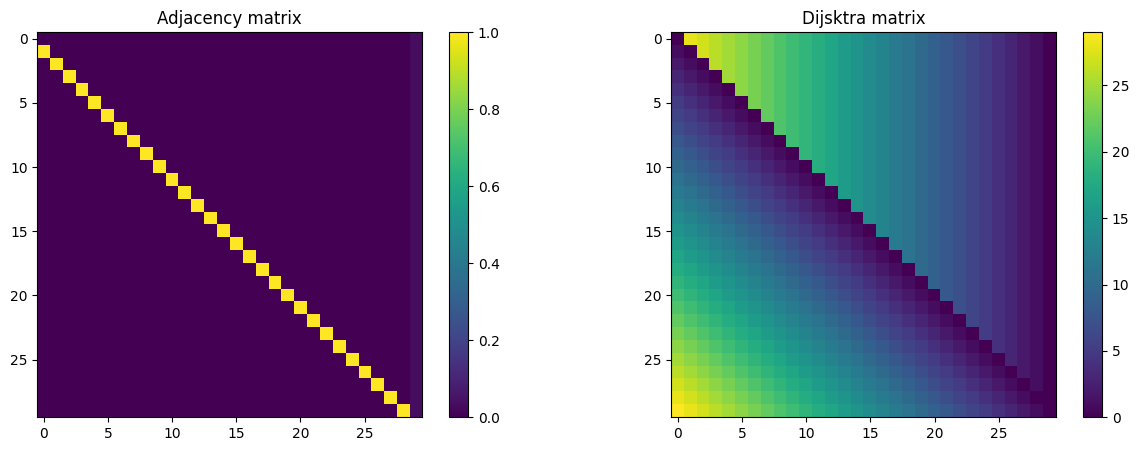

In [3]:
rng = jax.random.PRNGKey(1)

n_states, n_acts = 30, 3
trans_matrix = 0*jax.random.normal(rng, (n_acts, n_states, n_states)) + 10*jnp.eye(n_states, k=-1)
trans_matrix = jax.nn.softmax(trans_matrix*1e6, axis=-2)
A = trans_matrix.max(axis=0)
D = dijkstra(A)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Adjacency matrix')
plt.imshow(A, vmin=0, vmax=1)
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Dijsktra matrix')
plt.imshow(D)
plt.colorbar()

plt.show()



  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/ny/19b3c5357vzbxc3hyg919d9r0000gn/T/ipykernel_83561/1576931604.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*pos[i], c=[0, 0, 1, .5], marker='o', s=100, zorder=100, label='agent state')


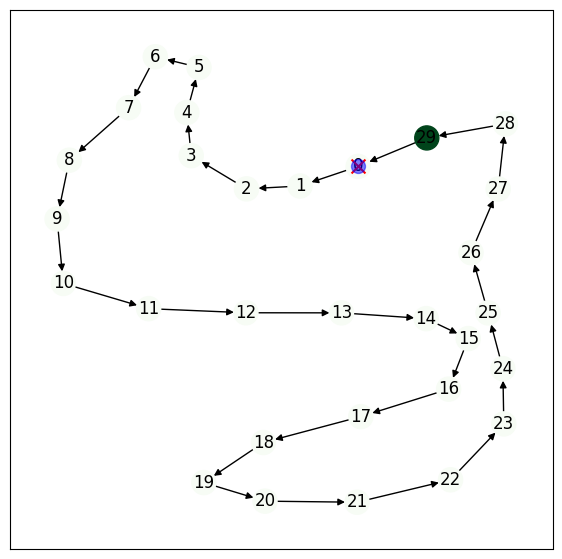

In [4]:
def generate_animation():
    np.random.seed(0)
    G = nx.DiGraph()
    G.add_nodes_from(list(range(n_states)))
    for act in range(n_acts):
        node_from = jnp.arange(n_states).tolist()
        node_to = jnp.argmax(trans_matrix[act], axis=-2).tolist()
        G.add_edges_from(list(zip(node_from, node_to)))

    # pos = nx.circular_layout(G)
    # pos = nx.shell_layout(G)
    pos = nx.spring_layout(G)

    # c = ['#1f77b4' for _ in range(n_states)]
    # c = [(31/255.,119/255.,180/255.,255/255.) for _ in range(n_states)]
    # c[0] = (0, 0, 1, 1)
    # c[-1] = (1, 0, 0, 1)
    # c = [(0, 1, 0, 1) for _ in range(n_states)]
    # rews = jnp.arange(n_states)
    rews = jnp.zeros(n_states)
    rews = rews.at[-1].set(1.)
    c = (rews-rews.min())/(rews.max()-rews.min() + 1e-5)

    fig = plt.figure(figsize=(7, 7))
    camera = Camera(fig)
    
    for i in tqdm(range(1)):
        nx.draw_networkx(G, with_labels=True, node_color=c, pos=pos, cmap='Greens')
        plt.scatter(*pos[0], c='r', marker='x', s=100, zorder=100, label='start state')
        plt.scatter(*pos[i], c=[0, 0, 1, .5], marker='o', s=100, zorder=100, label='agent state')
        camera.snap()
    animation = camera.animate()
    animation.save('animation.gif')

generate_animation()


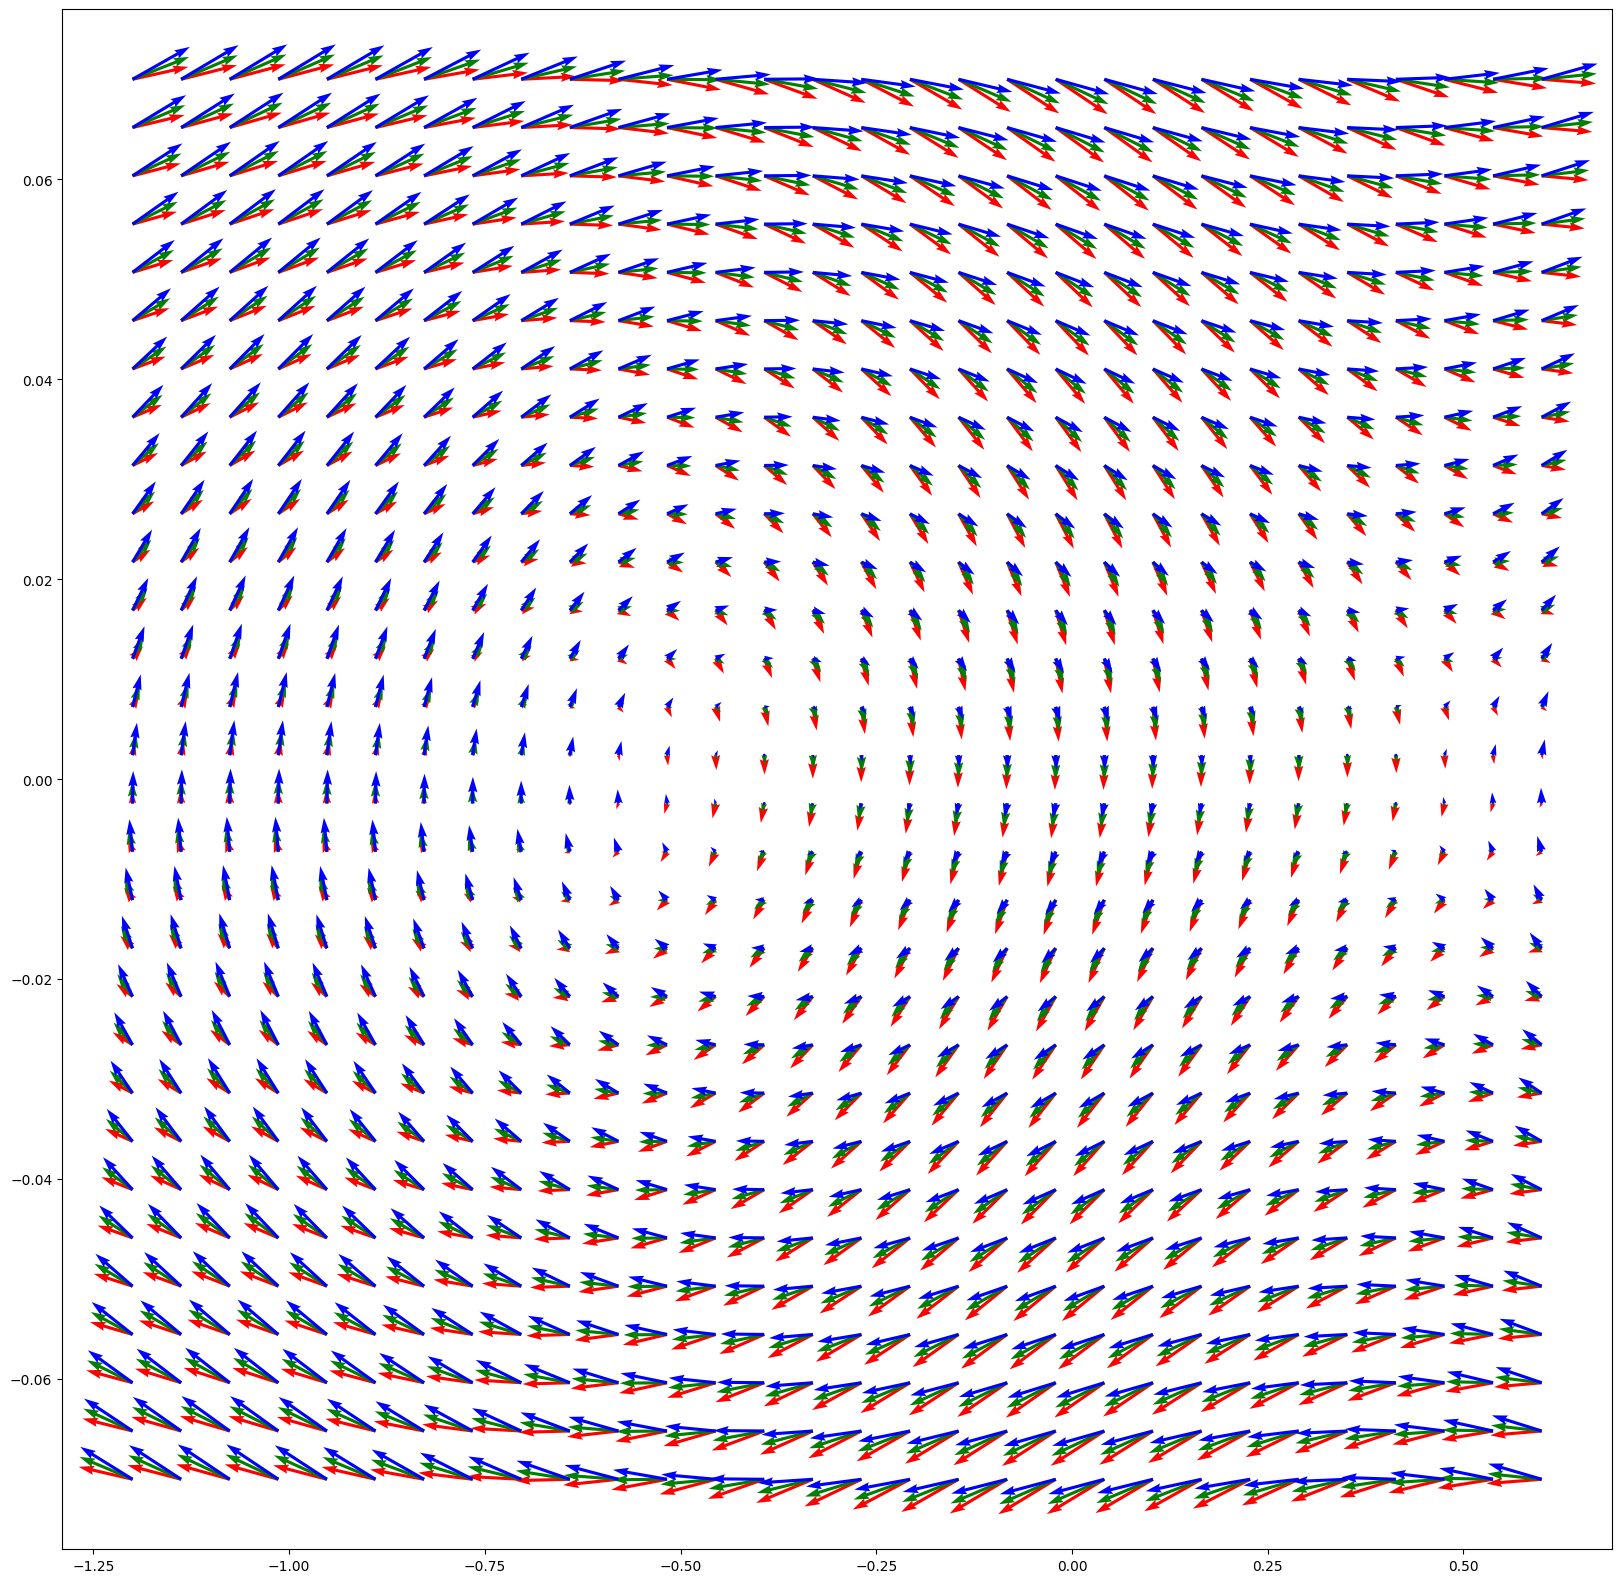

In [5]:
force, gravity = 0.001, 0.0025
p = jnp.linspace(-1.2, 0.6, 30)
v = jnp.linspace(-0.07, 0.07, 30)
p, v = jnp.meshgrid(p, v, indexing='ij')
acts = jnp.arange(3)

vn = v+(acts[:, None, None]-1)*force - jnp.cos(3*p)*gravity
pn = p+vn

p, v = repeat(p, 'i j -> 3 i j').flatten(), repeat(v, 'i j -> 3 i j').flatten()
pn, vn = pn.flatten(), vn.flatten()

c = ['r']*900 + ['g']*900 + ['b']*900

plt.figure(figsize=(20, 20))
plt.quiver(p, v, pn-p, vn-v, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)
plt.show()

In [6]:
class Trans(nn.Module):
    d_state: int
    n_acts: int
    delta: True

    def setup(self):
        self.seq = nn.Sequential([
            nn.Dense(self.d_state, kernel_init=jax.nn.initializers.orthogonal(), bias_init=jax.nn.initializers.normal()),
            nn.tanh,
            nn.Dense(self.d_state),
            nn.tanh,
            nn.Dense(self.n_acts*self.d_state),
        ])

    def __call__(self, state):
        state_n = 0.3*self.seq(state).reshape(self.n_acts, self.d_state)
        if self.delta:
            state_n = state + state_n
        return state_n

rng = jax.random.PRNGKey(2)
trans = Trans(2, 3, True)
rng, _rng = jax.random.split(rng)
params = trans.init(_rng, jnp.zeros(2))


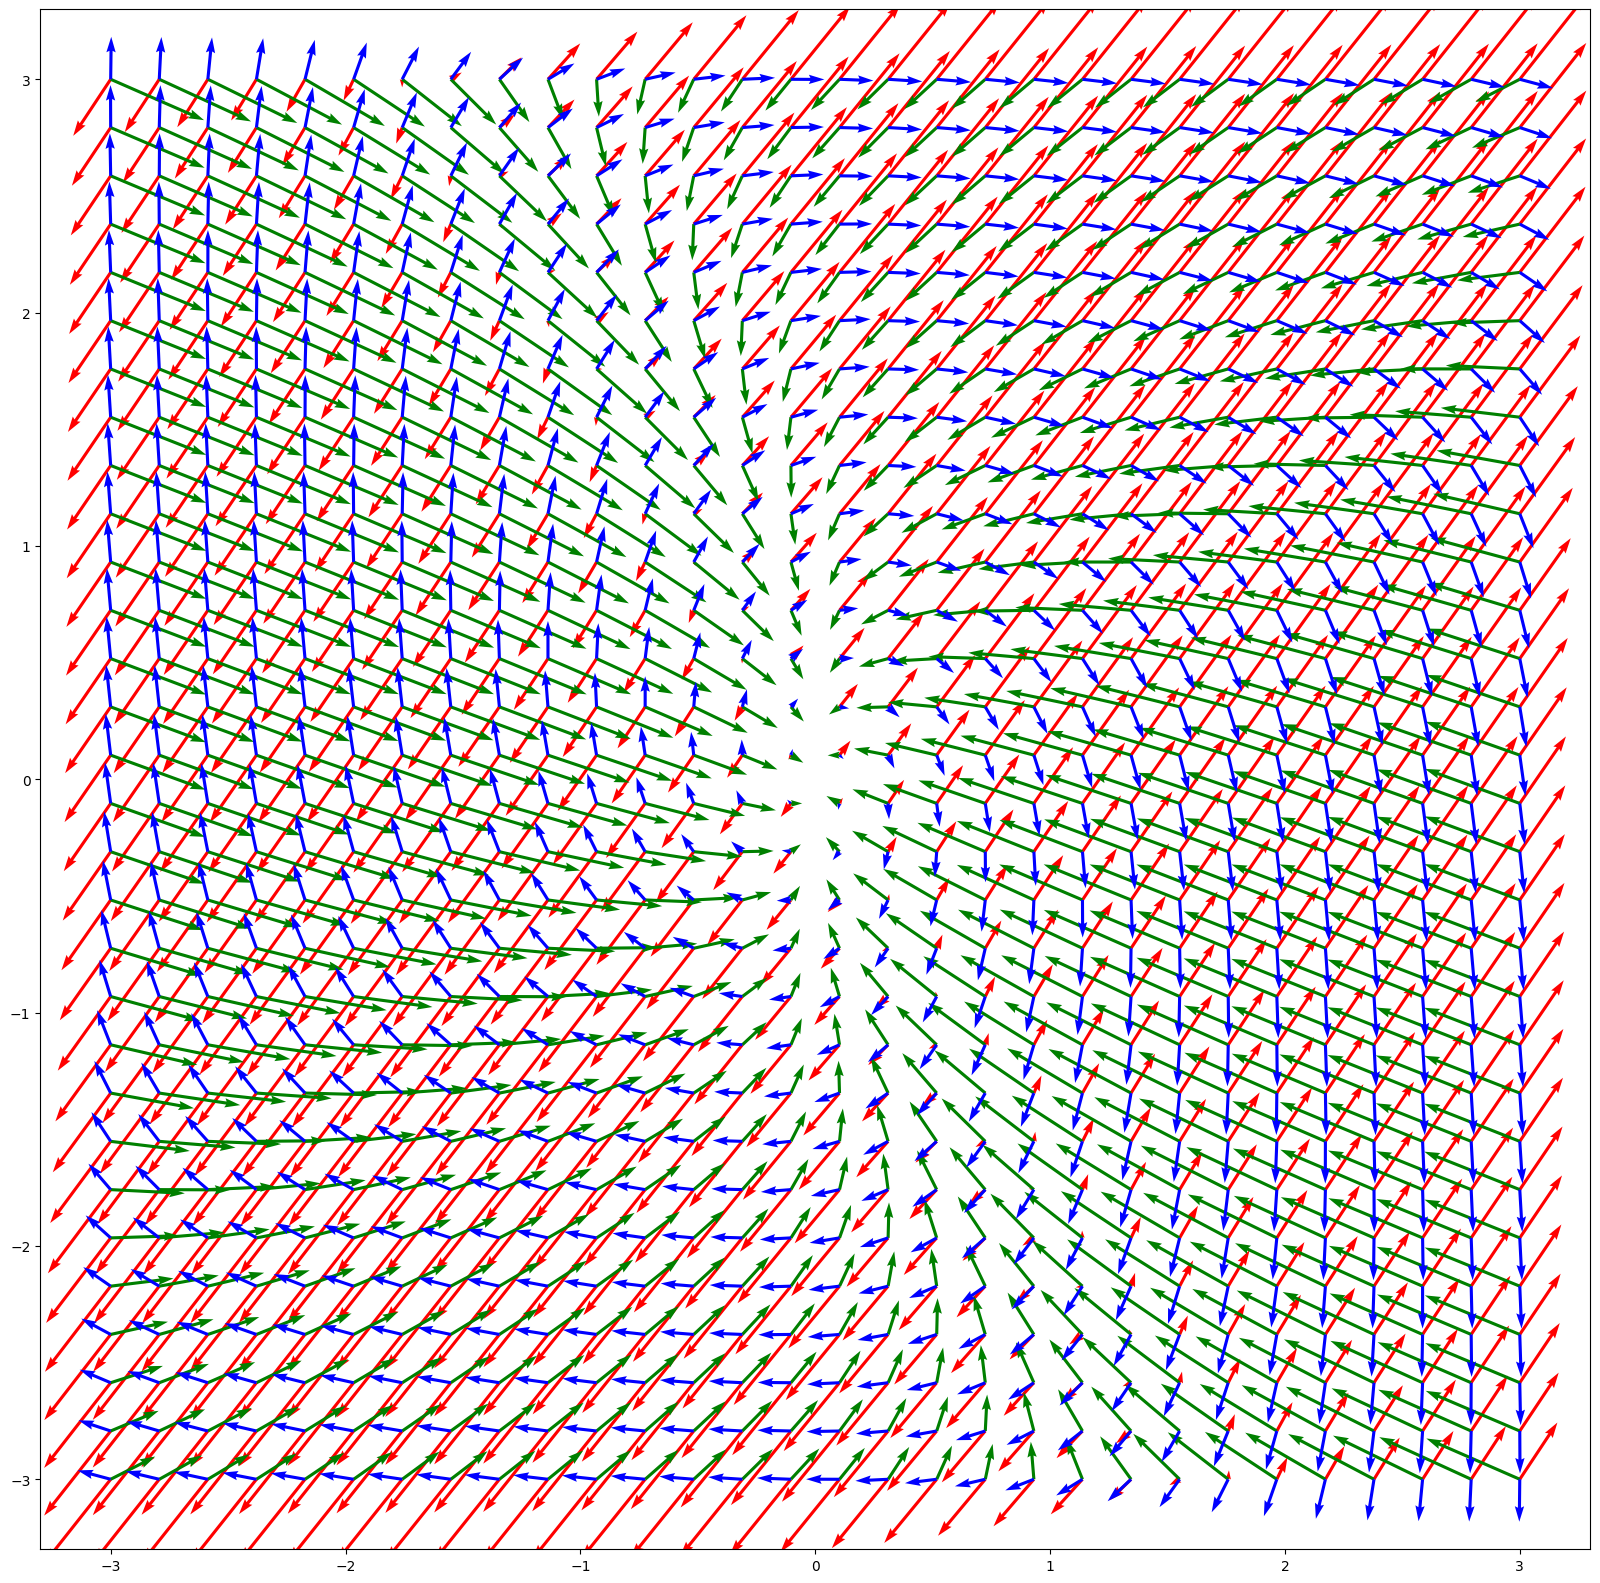

In [7]:
x = jnp.linspace(-3, 3, 30)
y = jnp.linspace(-3, 3, 30)
x, y = jnp.meshgrid(x, y, indexing='ij')
acts = jnp.arange(3)

x = jnp.stack([x, y], axis=-1)
xn = jax.vmap(jax.vmap(partial(trans.apply, params)))(x)
xn = rearrange(xn, 'i j a s -> a i j s')

x = repeat(x, 'i j s -> 3 i j s')
x, y = x[:, :, :, 0].flatten(), x[:, :, :, 1].flatten()
xn, yn = xn[:, :, :, 0].flatten(), xn[:, :, :, 1].flatten()

c = ['r']*900 + ['g']*900 + ['b']*900

plt.figure(figsize=(20, 20))
plt.quiver(x, y, xn-x, yn-y, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)
plt.show()

In [59]:
from mdps import smdp, csmdp

(3, 900, 2) (3, 900, 2)


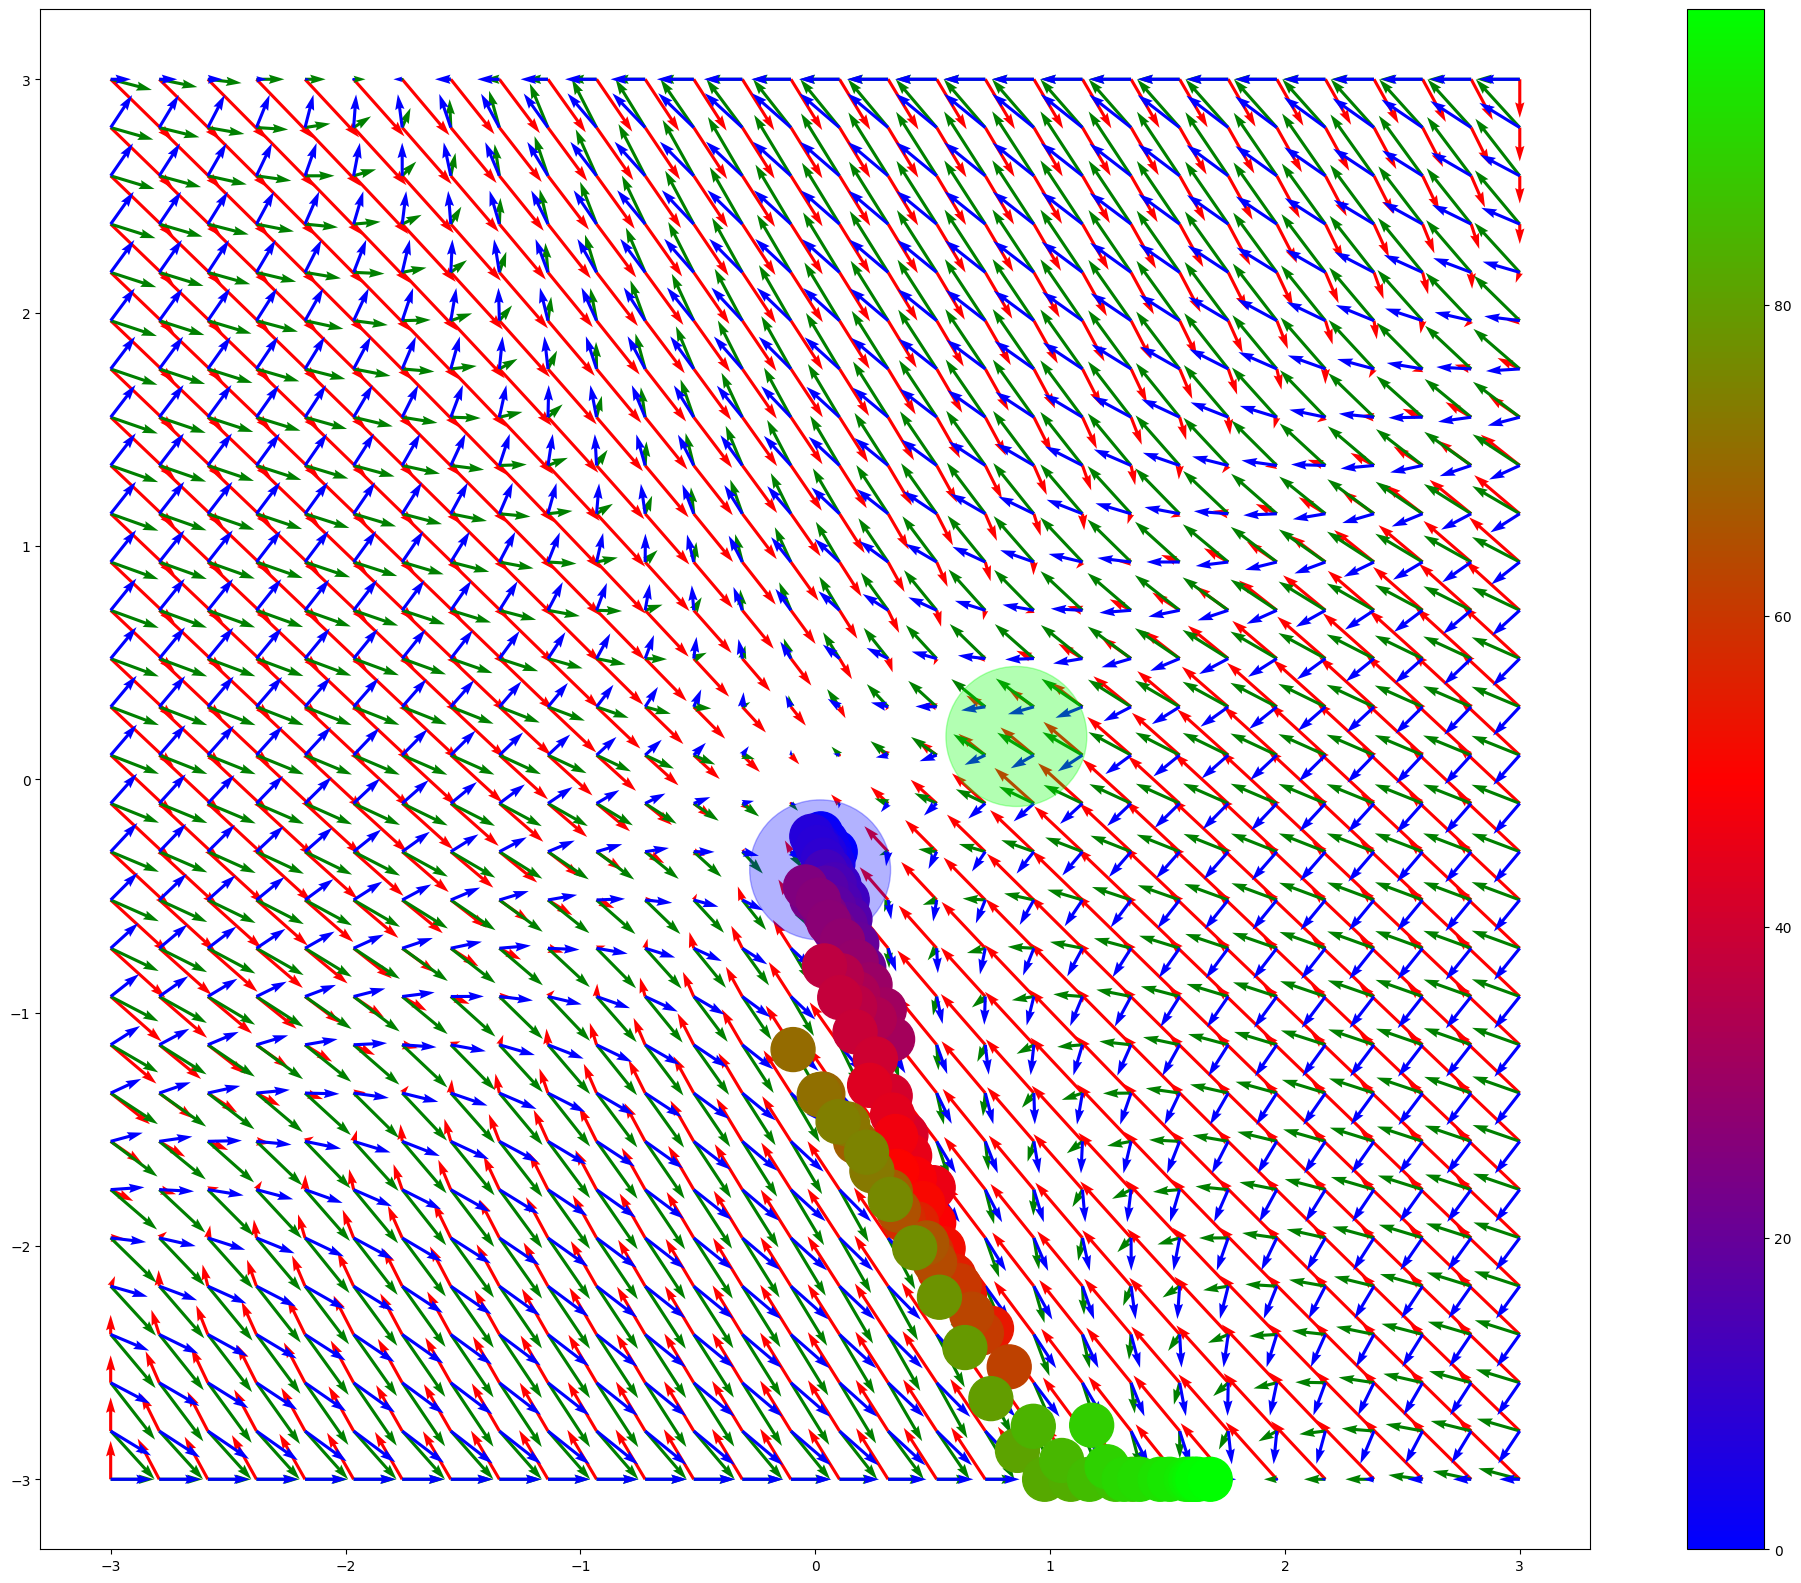

In [98]:
n_acts = 3
model_init = csmdp.Init(d_state=2)
model_trans = csmdp.Transition2(d_state=2, n_acts=n_acts, delta=True)
model_obs = smdp.IdentityObs()
model_rew = csmdp.Reward(d_state=2)
model_done = smdp.NeverDone()
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)


rng = jax.random.PRNGKey(12)
env_params = env.sample_params(rng)

x = jnp.linspace(-3, 3, 30)
x, y = jnp.meshgrid(x, x, indexing='ij')
state = rearrange(jnp.stack([x, y], axis=-1), "i j s -> (i j) s")
act = jnp.arange(n_acts)

rng, _rng = split(rng)
step_fn = partial(env.step, params=env_params)
state_n, _, _, _, _ = jax.vmap(jax.vmap(step_fn, in_axes=(None, 0, None)), in_axes=(None, None, 0))(_rng, state, act)

state = repeat(state, 'ij s -> a ij s', a=n_acts)

print(state.shape, state_n.shape)

c = ['r']*900 + ['g']*900 + ['b']*900

plt.figure(figsize=(25, 20))
x, y, xn, yn = state[..., 0].flatten(), state[..., 1].flatten(), state_n[..., 0].flatten(), state_n[..., 1].flatten()
plt.quiver(x, y, xn-x, yn-y, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)

state_start = env_params['params_init']['params']['state_start']
dist_thresh = model_init.dist_thresh
circle_start = plt.Circle(state_start, dist_thresh, color=[0, 0, 1, .3], fill=True)
plt.gca().add_patch(circle_start)

state_goal = env_params['params_rew']['params']['state_goal']
dist_thresh = model_rew.dist_thresh
circle_goal = plt.Circle(state_goal, dist_thresh, color=[0, 1, 0, .3], fill=True)
plt.gca().add_patch(circle_goal)


states = []
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
state, obs = env.reset(_rng, env_params)
for i in range(100):
    states.append(state)
    rng, _rng = split(rng)
    act = env.action_space(env_params).sample(_rng)
    rng, _rng = split(rng)
    state, obs, rew, done, info = env.step(rng, state, act, env_params)
states = jnp.stack(states)


plt.scatter(*states.T, c=np.arange(len(states)), s=1000, cmap='brg')
plt.colorbar()

plt.show()





3

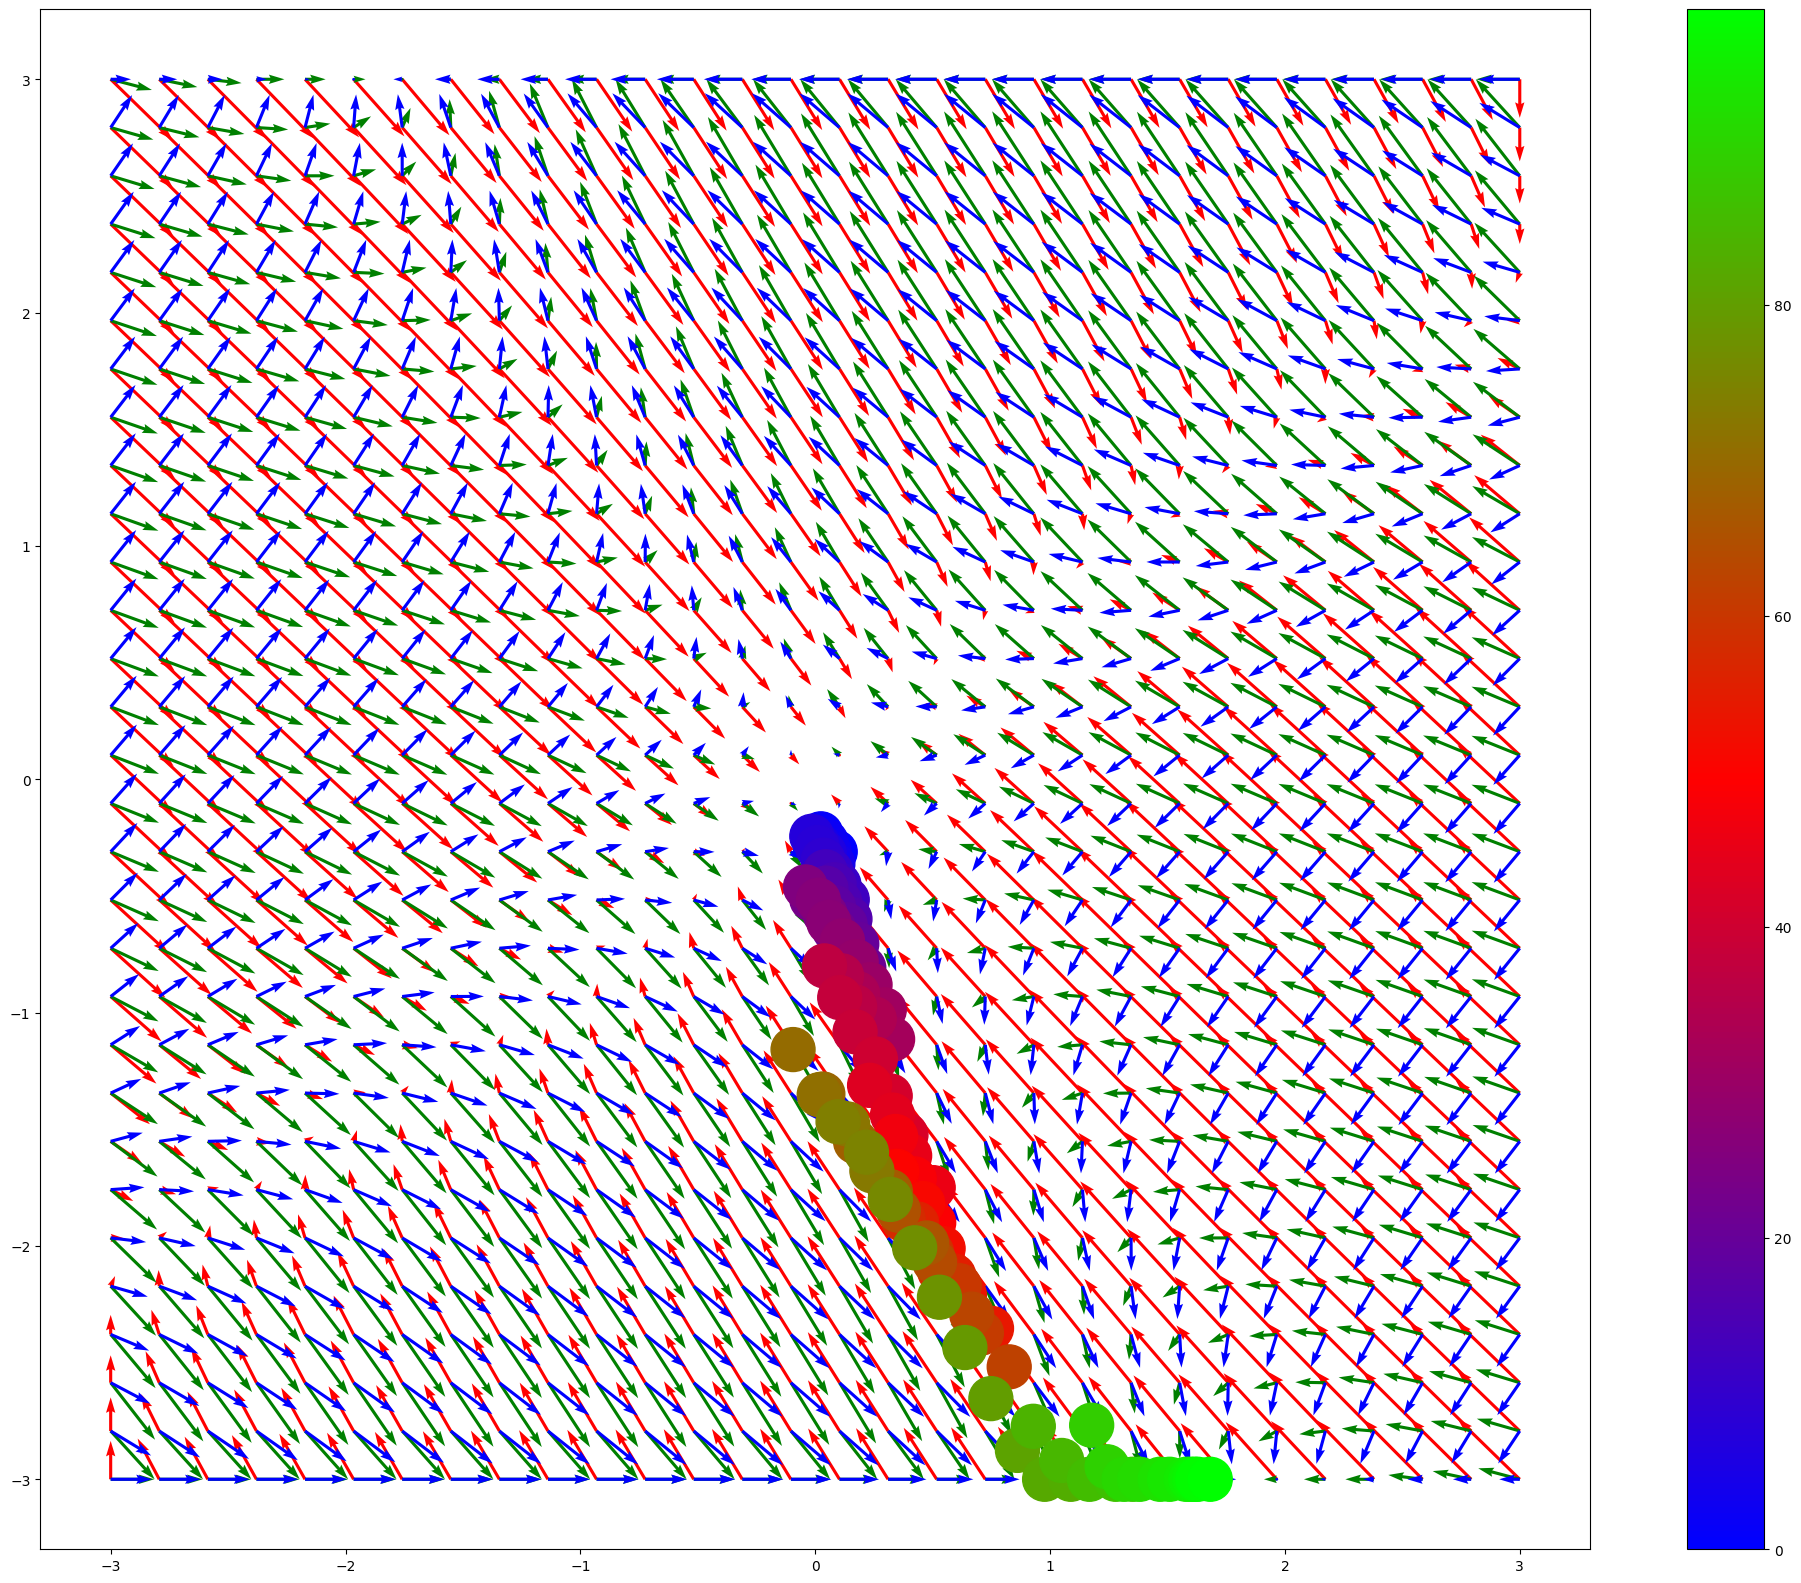

In [135]:
def viz_env(env, env_params, xlim=(-3, 3), ylim=(-3, 3), states=None):
    n_acts = env.action_space(env_params).n
    
    x, y = jnp.linspace(*xlim, 30), jnp.linspace(*ylim, 30)
    x, y = jnp.meshgrid(x, y, indexing='ij')
    state = rearrange(jnp.stack([x, y], axis=-1), "i j s -> (i j) s")
    act = jnp.arange(n_acts)

    _rng = jax.random.PRNGKey(0)
    step_fn = partial(env.step, params=env_params)
    _, state_n, _, _, _ = jax.vmap(jax.vmap(step_fn, in_axes=(None, 0, None)), in_axes=(None, None, 0))(_rng, state, act)

    state = repeat(state, 'ij s -> a ij s', a=n_acts)

    c = ['r']*900 + ['g']*900 + ['b']*900

    plt.figure(figsize=(25, 20))
    x, y, xn, yn = state[..., 0].flatten(), state[..., 1].flatten(), state_n[..., 0].flatten(), state_n[..., 1].flatten()
    plt.quiver(x, y, xn-x, yn-y, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)

    # state_start = env_params['params_init']['params']['state_start']
    # dist_thresh = model_init.dist_thresh
    # circle_start = plt.Circle(state_start, dist_thresh, color=[0, 0, 1, .3], fill=True)
    # plt.gca().add_patch(circle_start)
    # 
    # state_goal = env_params['params_rew']['params']['state_goal']
    # dist_thresh = model_rew.dist_thresh
    # circle_goal = plt.Circle(state_goal, dist_thresh, color=[0, 1, 0, .3], fill=True)
    # plt.gca().add_patch(circle_goal)
    
    if states is not None:
        plt.scatter(*states.T, c=np.arange(len(states)), s=1000, cmap='brg')
        plt.colorbar()
    plt.show()


n_acts = 3
model_init = csmdp.Init(d_state=2)
model_trans = csmdp.Transition2(d_state=2, n_acts=n_acts, delta=True)
model_obs = smdp.IdentityObs()
model_rew = csmdp.Reward(d_state=2)
model_done = smdp.NeverDone()
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)

rng = jax.random.PRNGKey(12)
env_params = env.sample_params(rng)

states = []
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
obs, state = env.reset(_rng, env_params)
for i in range(100):
    states.append(state)
    rng, _rng = split(rng)
    act = env.action_space(env_params).sample(_rng)
    rng, _rng = split(rng)
    obs, state, rew, done, info = env.step(_rng, state, act, env_params)
states = jnp.stack(states)


viz_env(env, env_params, states=states)



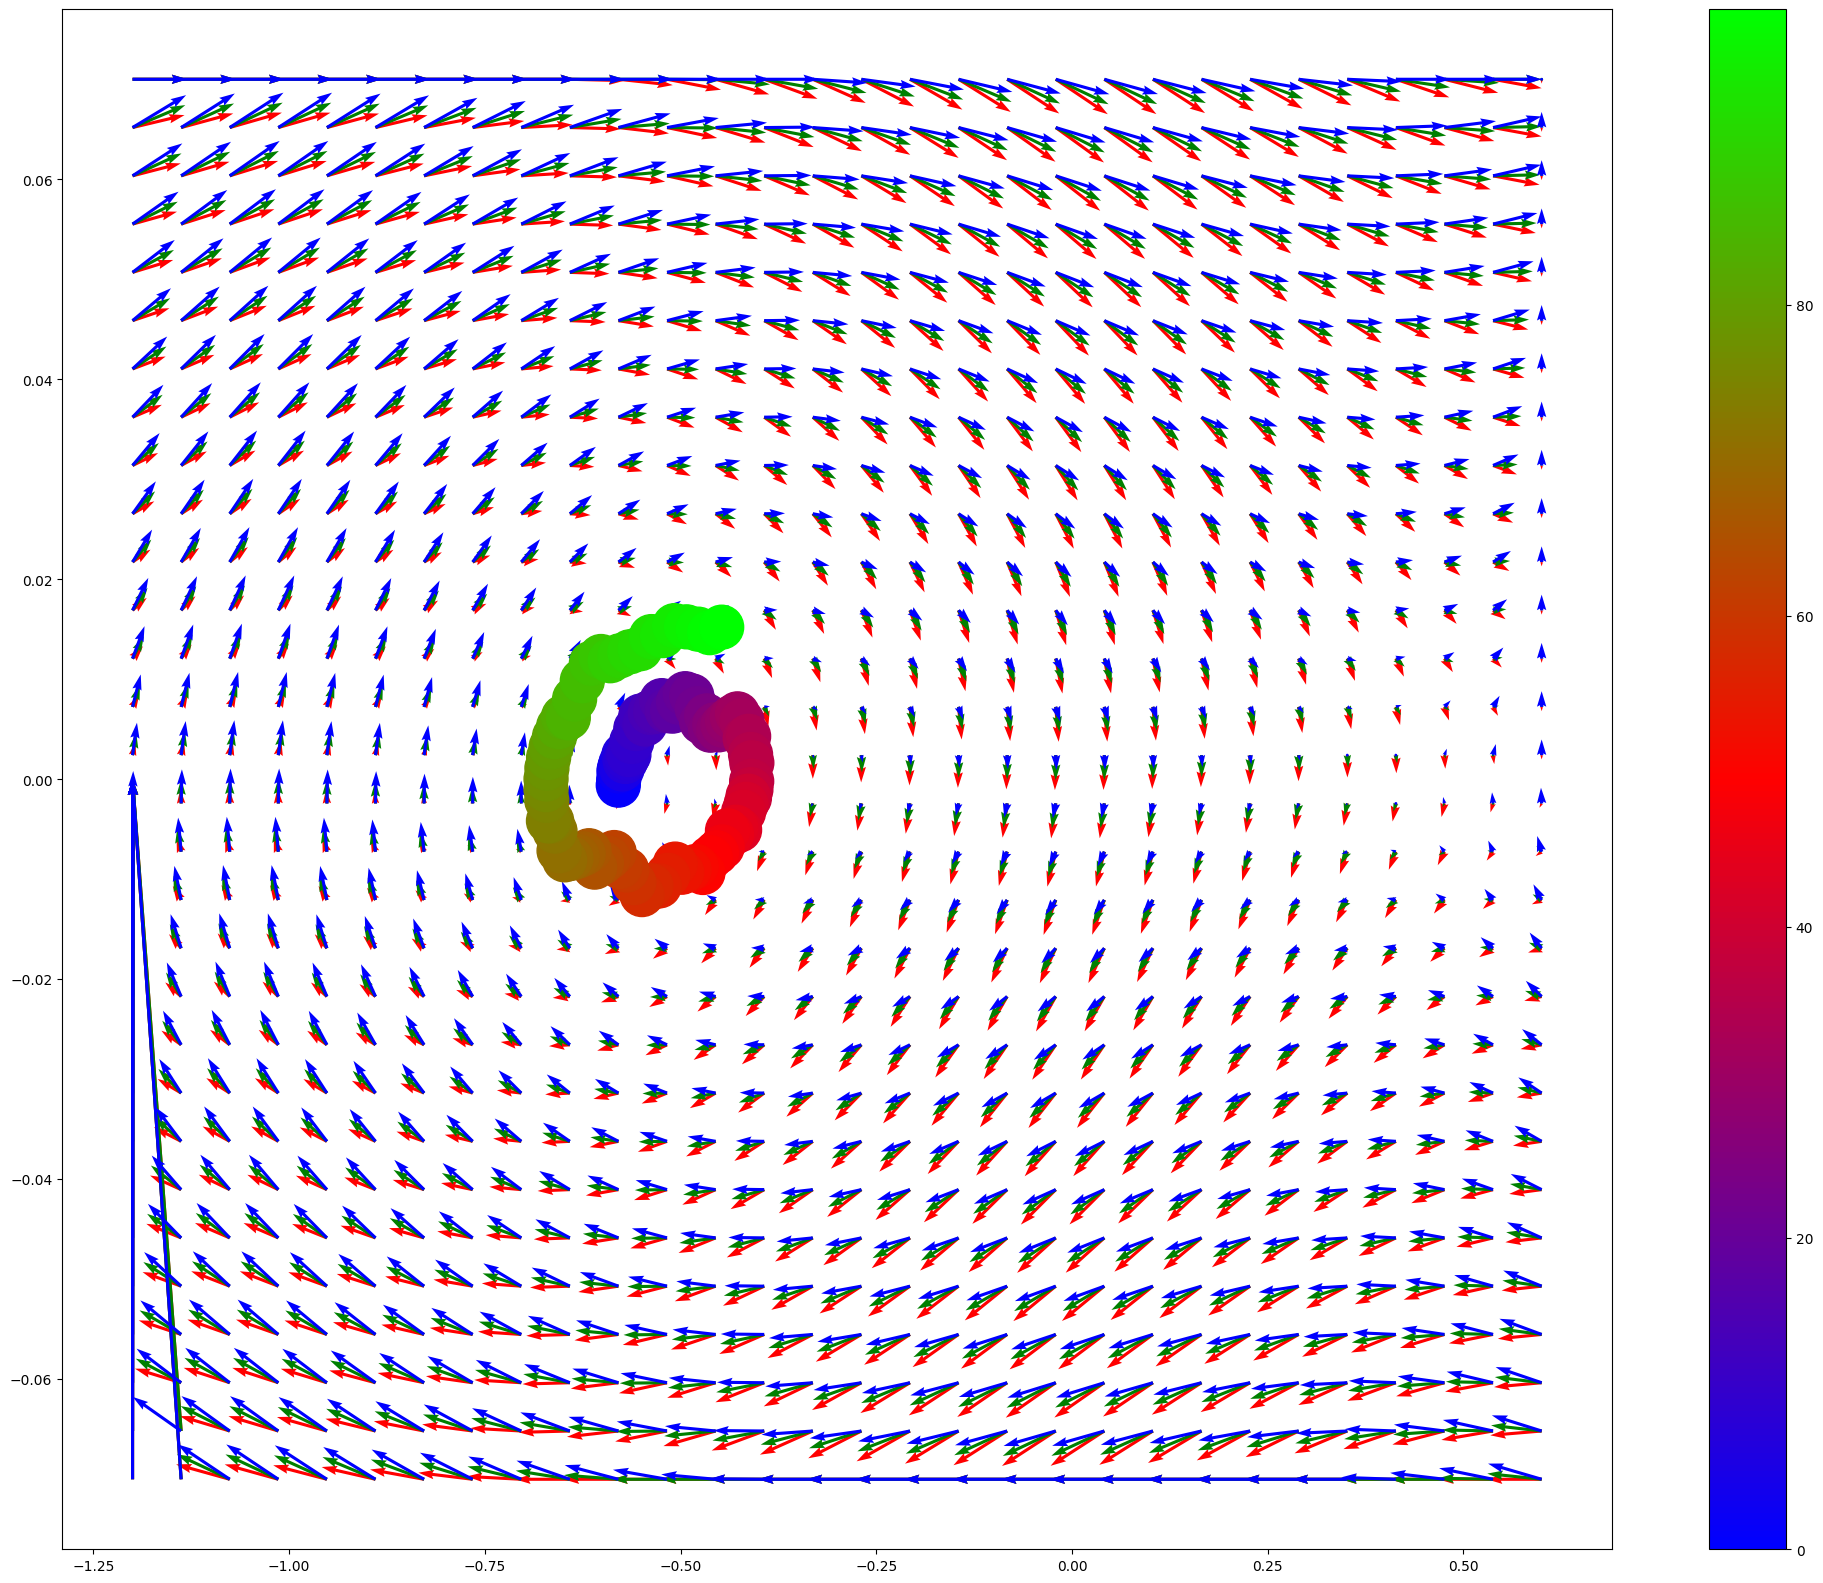

In [136]:
n_acts = 3


from mdps.natural_mdps import MountainCar
from gymnax.environments.classic_control.mountain_car import EnvState
class MyMountainCar(MountainCar):
    def reset_env(self, rng, params):
        obs, state = super().reset_env(rng, params)
        state = jnp.array([state.position, state.velocity])
        return obs, state
    def step_env(self, rng, state, act, params):
        obs, state, rew, done, info = super().step_env(rng, EnvState(position=state[0], velocity=state[1], time=0), act, params)
        state = jnp.array([state.position, state.velocity])
        return obs, state, rew, done, info
env = MyMountainCar()

rng = jax.random.PRNGKey(12)
env_params = env.sample_params(rng)

states = []
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
obs, state = env.reset(_rng, env_params)
for i in range(100):
    states.append(state)
    rng, _rng = split(rng)
    act = env.action_space(env_params).sample(_rng)
    rng, _rng = split(rng)
    obs, state, rew, done, info = env.step(_rng, state, act, env_params)
states = jnp.stack(states)

viz_env(env, env_params, xlim=(-1.2, 0.6), ylim=(-0.07, 0.07), states=states)


In [103]:
# maybe bias the transition matrix to have bound state_i-state_j must be small id...

In [ ]:
# graph the correlation of between phi(s), phi(s') vs the time difference between s and s'
# gives and idea how smooth phi is temporally